In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.utils import resample, shuffle
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 500)

In [2]:
tr = pd.read_csv('train.csv')
tr = tr.fillna('N')
tr.tail()

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey
1521782,6322,91008,15189,578.38,5,75,Y,8,N,N,0,6,N,0,4,191642.0,209,38222,N,5817,102,0,1478280
1521783,3226,145107,116252,435.32,5,75,Y,8,N,N,0,6,N,0,13,102338.0,192,90135,N,1458,102,0,661087
1521784,6769,162168,93598,1.38,5,75,Y,8,N,N,0,6,N,0,29,234618.0,373,79246,N,5817,102,0,167073
1521785,6032,45406,197460,1.38,5,75,Y,2,N,N,0,6,N,0,24,215218.0,373,79246,N,5817,102,0,338215
1521786,6716,48723,176440,406.59,5,75,N,5,N,N,0,6,N,0,13,163603.0,251,69607,N,2310,102,0,1055258


In [3]:
ts = pd.read_csv('test.csv')
ts = ts.fillna('N')
ts.tail()

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey
421660,5975,147326,79511,633.76,5,62,N,2,N,N,5,N,0,116,111228.0,343,87282,N,5817,102,0,1187507
421661,6716,14305,136493,952.84,5,62,N,5,N,N,8,N,0,107,85839.0,245,48784,N,5859,102,0,1182598
421662,5975,156543,137963,713.42,5,62,N,4,N,N,5,N,0,111,184921.0,263,98326,N,5817,102,0,898724
421663,6231,156543,137964,903.94,5,62,N,5,N,N,5,N,0,114,144434.0,251,17763,N,5817,102,0,971467
421664,6769,131985,98699,760.09,5,62,N,4,N,N,5,N,0,116,162804.0,251,78019,N,3294,102,0,101230


In [5]:
tr['hour'] = (tr.loctm // 10000).astype(int)
ts['hour'] = (ts.loctm // 10000).astype(int)

In [9]:
tr1 = tr[tr.locdt <= 30]
tr2 = tr[(tr.locdt > 30) & (tr.locdt <= 60)]
tr3 = tr[(tr.locdt > 60) & (tr.locdt <= 90)]
ts['frequence'] = ts.cano.map(ts.cano.value_counts())
tr['frequence'] = (np.where(tr.locdt <= 30, tr.cano.map(tr1.cano.value_counts()), 
                  (np.where(tr.locdt <= 60, tr.cano.map(tr2.cano.value_counts()), tr.cano.map(tr3.cano.value_counts()))
                            ))).astype(int)

In [10]:
tr[(tr.cano == 38038) & (tr.locdt < 90)][['cano', 'locdt', 'frequence']][:10]

,cano,locdt,frequence
0,38038,33,21
16628,38038,34,21
18097,38038,33,21
27691,38038,49,21
34354,38038,49,21
64552,38038,36,21
122151,38038,23,18
130577,38038,76,41
153578,38038,30,18
167650,38038,86,41


In [11]:
ts[['cano', 'locdt', 'frequence']][:10]

,cano,locdt,frequence
0,116799,102,11
1,116799,102,11
2,116799,100,11
3,116799,100,11
4,116799,102,11
5,116799,102,11
6,116799,100,11
7,116799,102,11
8,116799,95,11
9,116799,102,11


In [12]:
new_bin = np.append(np.array([-1]), np.geomspace(1, 10000, num=49))
tr['conam_label'] = pd.cut(tr.conam, bins=new_bin, labels=[k for k in range(len(new_bin)-1)]).cat.codes
ts['conam_label'] = pd.cut(ts.conam, bins=new_bin, labels=[k for k in range(len(new_bin)-1)]).cat.codes

In [13]:
category_features = ['acqic', 'conam_label', 'csmcu', 'ecfg', 'etymd', 'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'mcc', 'mchno', 'scity', 'stocn', 'stscd']

for feature in category_features:
    
    tr_table = tr.groupby([feature, 'fraud_ind']).size()
    tr_table_precentage = tr_table / tr_table.groupby(level=0).sum()
    
    fraud_index = tr_table_precentage[:, 1].index
    tr['{}_proba'.format(feature)] = np.where(np.isin(tr[feature], fraud_index) == True, tr[feature].map(tr_table_precentage.loc[:, 1]), 0.0)
    ts['{}_proba'.format(feature)] = np.where(np.isin(ts[feature], fraud_index) == True, ts[feature].map(tr_table_precentage.loc[:, 1]), 0.0)

## New method for Groupby "cano" and count each categorical features

In [15]:
# # New method..

for col in category_features:
    vc_table = tr.groupby(['cano', col]).size()
    vc_precentage = vc_table / vc_table.groupby(level=0).sum()
    vc_precentage.index = ['{}_{}'.format(i, j) for i, j in vc_precentage.index]
    tr["{}_personal".format(col)] = (tr['cano'].astype('str') + '_' + tr[col].astype('str')).map(vc_precentage)
#     print(np.array_equal((val['cano'].astype('str') + '_' + val[col].astype('str')).map(vc_precentage), val['{}_personal'.format(col)]))

for col in category_features:
    vc_table = ts.groupby(['cano', col]).size()
    vc_precentage = vc_table / vc_table.groupby(level=0).sum()
    vc_precentage.index = ['{}_{}'.format(i, j) for i, j in vc_precentage.index]
    ts["{}_personal".format(col)] = (ts['cano'].astype('str') + '_' + ts[col].astype('str')).map(vc_precentage)

In [16]:
temp1 = np.zeros(tr.shape[0])
temp2 = np.zeros(ts.shape[0])

for i in category_features:
    temp1 += tr["{}_proba".format(i)].values 
    temp2 += ts["{}_proba".format(i)].values

tr['Total'] = temp1 / len(category_features)
ts['Total'] = temp2 / len(category_features)

In [17]:
ts.tail()

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey,hour,frequence,conam_label,acqic_proba,conam_label_proba,csmcu_proba,ecfg_proba,etymd_proba,flbmk_proba,flg_3dsmk_proba,hcefg_proba,insfg_proba,iterm_proba,mcc_proba,mchno_proba,scity_proba,stocn_proba,stscd_proba,acqic_personal,conam_label_personal,csmcu_personal,ecfg_personal,etymd_personal,flbmk_personal,flg_3dsmk_personal,hcefg_personal,insfg_personal,iterm_personal,mcc_personal,mchno_personal,scity_personal,stocn_personal,stscd_personal,Total
421660,5975,147326,79511,633.76,5,62,N,2,N,N,5,N,0,116,111228.0,343,87282,N,5817,102,0,1187507,11,1,34,0.000376,0.007355,0.00718,0.002523,0.020664,0.013363,0.013898,0.014241,0.013733,0.013733,0.000117,0.0,0.000959,0.000948,0.009768,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.007924
421661,6716,14305,136493,952.84,5,62,N,5,N,N,8,N,0,107,85839.0,245,48784,N,5859,102,0,1182598,8,1,36,0.000695,0.020193,0.00718,0.002523,0.000502,0.013363,0.013898,0.000000,0.013733,0.013733,0.001070,0.0,0.000356,0.000948,0.009768,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.006531
421662,5975,156543,137963,713.42,5,62,N,4,N,N,5,N,0,111,184921.0,263,98326,N,5817,102,0,898724,18,1,35,0.000376,0.008334,0.00718,0.002523,0.000546,0.013363,0.013898,0.014241,0.013733,0.013733,0.000951,0.0,0.000959,0.000948,0.009768,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.006704
421663,6231,156543,137964,903.94,5,62,N,5,N,N,5,N,0,114,144434.0,251,17763,N,5817,102,0,971467,14,1,36,0.000601,0.020193,0.00718,0.002523,0.000502,0.013363,0.013898,0.014241,0.013733,0.013733,0.000802,0.0,0.000959,0.000948,0.009768,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.007496
421664,6769,131985,98699,760.09,5,62,N,4,N,N,5,N,0,116,162804.0,251,78019,N,3294,102,0,101230,16,1,35,0.001040,0.008334,0.00718,0.002523,0.000546,0.013363,0.013898,0.014241,0.013733,0.013733,0.000802,0.0,0.000000,0.000948,0.009768,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.006674


In [18]:
tr.tail()

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey,hour,frequence,conam_label,acqic_proba,conam_label_proba,csmcu_proba,ecfg_proba,etymd_proba,flbmk_proba,flg_3dsmk_proba,hcefg_proba,insfg_proba,iterm_proba,mcc_proba,mchno_proba,scity_proba,stocn_proba,stscd_proba,acqic_personal,conam_label_personal,csmcu_personal,ecfg_personal,etymd_personal,flbmk_personal,flg_3dsmk_personal,hcefg_personal,insfg_personal,iterm_personal,mcc_personal,mchno_personal,scity_personal,stocn_personal,stscd_personal,Total
1521782,6322,91008,15189,578.38,5,75,Y,8,N,N,0,6,N,0,4,191642.0,209,38222,N,5817,102,0,1478280,19,5,34,0.000649,0.007355,0.0155,0.045169,0.047411,0.013363,0.013898,0.0155,0.013733,0.013733,0.003215,0.000000,0.000959,0.000948,0.009768,0.181818,0.090909,1.000000,0.181818,0.181818,1.000000,1.000000,1.000000,1.000000,1.000000,0.272727,0.181818,0.454545,1.000000,1.0,0.013413
1521783,3226,145107,116252,435.32,5,75,Y,8,N,N,0,6,N,0,13,102338.0,192,90135,N,1458,102,0,661087,10,39,32,0.004677,0.008732,0.0155,0.045169,0.047411,0.013363,0.013898,0.0155,0.013733,0.013733,0.085390,0.010008,0.004488,0.000948,0.009768,0.500000,0.321429,1.000000,0.589286,0.589286,1.000000,1.000000,1.000000,0.982143,0.982143,0.589286,0.232143,0.500000,0.875000,1.0,0.020155
1521784,6769,162168,93598,1.38,5,75,Y,8,N,N,0,6,N,0,29,234618.0,373,79246,N,5817,102,0,167073,23,5,2,0.001040,0.012108,0.0155,0.045169,0.047411,0.013363,0.013898,0.0155,0.013733,0.013733,0.011203,0.001036,0.000959,0.000948,0.009768,0.571429,0.142857,0.142857,0.857143,0.857143,1.000000,0.428571,0.142857,1.000000,1.000000,0.285714,0.142857,0.642857,1.000000,1.0,0.014358
1521785,6032,45406,197460,1.38,5,75,Y,2,N,N,0,6,N,0,24,215218.0,373,79246,N,5817,102,0,338215,21,12,2,0.002506,0.012108,0.0155,0.045169,0.020664,0.013363,0.013898,0.0155,0.013733,0.013733,0.011203,0.001036,0.000959,0.000948,0.009768,0.592593,0.148148,0.148148,0.370370,0.592593,0.962963,1.000000,0.148148,1.000000,1.000000,0.185185,0.148148,0.814815,1.000000,1.0,0.012673
1521786,6716,48723,176440,406.59,5,75,N,5,N,N,0,6,N,0,13,163603.0,251,69607,N,2310,102,0,1055258,16,12,32,0.000695,0.008732,0.0155,0.002523,0.000502,0.013363,0.013898,0.0155,0.013733,0.013733,0.000802,0.000000,0.000160,0.000948,0.009768,0.714286,0.214286,1.000000,0.785714,0.642857,1.000000,1.000000,1.000000,1.000000,1.000000,0.285714,0.285714,0.714286,0.928571,1.0,0.007324


In [19]:
tr = tr.drop(columns=['loctm'])
tr.replace(['N','Y'], [0, 1], inplace=True)
ts = ts.drop(columns=['loctm'])
ts.replace(['N','Y'], [0, 1], inplace=True)

In [20]:
print("0 : 1\n{} : {}".format(tr[tr.fraud_ind == 0].size//tr[tr.fraud_ind == 1].size, 1))
print(tr[tr.fraud_ind == 1].shape[0])

0 : 1
73 : 1
20355


In [21]:
tr_0 = tr[tr.fraud_ind == 0].copy().reset_index(drop=True)
tr_1 = tr[tr.fraud_ind == 1].copy().reset_index(drop=True)

Datasets = []

for i in range(11):
    group_0 = resample(tr_0, n_samples=20355 * 20, replace=True, random_state=i)
    group_1 = resample(tr_1, n_samples=20355, replace=False, random_state=i)
    sub_df = pd.concat([group_0, group_1],axis=0, ignore_index=True)
    sub_df = shuffle(sub_df).reset_index(drop=True)
    Datasets.append(sub_df)

In [23]:
XGBS = [XGBClassifier(random_state=i, max_depth=5, n_jobs=-1, learning_rate=0.3) for i in range(11)]
tr_col = Datasets[0].columns.tolist()
tr_col.remove('fraud_ind')
print(tr_col)

PRED = []
PRED2 = []
for i in range(11):
    
    tr_X = Datasets[i][tr_col]
    tr_y = Datasets[i]['fraud_ind']

    XGBS[i].fit(tr_X, tr_y)
    pred_y = XGBS[i].predict(ts[tr_col])
    pred_y2 = XGBS[i].predict_proba(ts[tr_col])
    
    PRED.append(np.array(pred_y))
    PRED2.append(np.array(pred_y2))

In [24]:
pred = np.where(np.array(PRED).mean(axis=0) > 0.5, 1, 0)

In [25]:
pred2 = np.where(np.array(PRED2)[:, :, 1].mean(axis=0) >= 0.5, 1, 0)

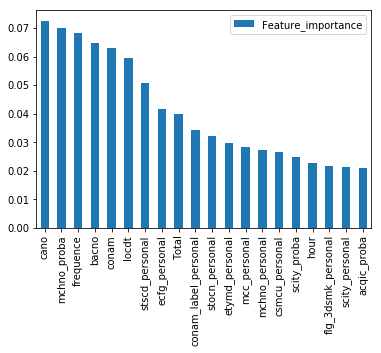

In [26]:
temp = np.zeros(len(tr_col))
for i in range(11):
    temp += XGBS[i].feature_importances_
    
f_im = pd.DataFrame(data=temp / 11, columns=['Feature_importance'], index=tr_col)
f_im.sort_values(by='Feature_importance', ascending=False)[:20].plot.bar()

In [31]:
ans = ts[['txkey']].copy()
ans['fraud_ind'] = pred
ans.tail()

,txkey,fraud_ind
421660,1187507,0
421661,1182598,0
421662,898724,0
421663,971467,0
421664,101230,0


In [32]:
ans.to_csv('ans_with_RFE.csv', index=False)

In [33]:
np.where(np.equal(pred, pred2) == False)[0].size

210